In [2]:
# Imports
from qiime2 import Metadata
import pandas as pd
from qiime2 import Artifact, sdk
from qiime2.plugins.dada2.methods import denoise_pyro # The samples were obtained through pyrosequencing
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_classifier.pipelines import classify_consensus_blast
import qiime2.plugins.feature_table.methods as ftm
import qiime2.plugins.feature_classifier.actions as feature_classifier_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
import qiime2.plugins.feature_table.actions as fta
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
from Bio import SeqIO
%matplotlib inline

matplotlib.use('module://ipykernel.pylab.backend_inline')
pm = sdk.PluginManager()
def see(artifact):
    from_format = artifact.format
    if issubclass(from_format, sdk.plugin_manager.SingleFileDirectoryFormatBase):
        from_format = artifact.format.file.format
    return set(pm.transformers[from_format].keys())
import os
import pandas
import qiime2
import tempfile

def v2frame(viz_fp: str) -> list:
    '''viz_fp is a path to the qiime2 visualization object'''
    viz = qiime2.Visualization.load(viz_fp)
    with tempfile.TemporaryDirectory() as tmpdir:
        viz.export_data(tmpdir)
        fp = os.path.join(tmpdir, 'quality-plot.html')
        ov = os.path.join(tmpdir, 'overview.html')
        dfs = pandas.read_html(fp, index_col=0)
        df2s = pandas.read_html(ov, index_col=0)
    return dfs + df2s

# Importing data from fastq
Qiime2 uses a compressed type of file format called an 'Artifact' for its analyses. Artifacts have different semantic types e.g. `FeatureData[Sequence]`, `Phylogeny[Unrooted]` depending on the type of data they contain. To begin the analysis, I need to import my fastq files into `FeatureData[SequencesWithQuality]` or `FeatureData[PairedEndSequencesWithQuality]`. 

Although all of these reads were prepared with Illumina devices, sequencing quality can vary between sequencing centres, meaning that each sample will likely need specific parameters for cleaning. Furthermore, two of the samples were sequenced with paired-end format. This means that I'll need to import each sample into five different artifacts, merging them together once they have been cleaned

Quality $(Q)$ is commonly measured in Phred scores, denoted as  $Q=-10 \log_{10}P$, where $P$ is the probability of an incorrect base call. Therefore, higher values for Phred indicate a lower probability of an erroneous base. Every base position is given a Phred score, and it is common to see the score decrease the longer the read 

```bash
# Relevant commands
qiime tools import \
  --type 'SampleData[PairedEndSequencesWithQuality]' \
  --input-path devon.tsv \
  --output-path devonFQ.qza \
  --input-format PairedEndFastqManifestPhred64V2

qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path neem.tsv \
  --output-path neem.qza \
  --input-format SingleEndFastqManifestPhred33V2
```

# Initial exploration
To get an idea of each sample's read quality, I used external tools: `FastQC` paired with `MultiQC`. I was mainly looking for the 

```bash
for sample in {Barrow_Alaska,Devon_ice_cap,Mutzagh_Ata,Greenland_ice_sheet,Neem}
    do 
        fastqc ${sample}/*
        multiqc $sample -f
    done
```

In [1]:
# Import data
qualities = pd.read_csv('', sep='\t')
pd.read_csv('data/TSV_data/barrow_high/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/barrow_high/fastqc_sequence_length_distribution_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/barrow_low/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/barrow_low/fastqc_sequence_length_distribution_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/cryoconite/fastqc_adapter_content_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/cryoconite/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/cryoconite/fastqc_sequence_length_distribution_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/devon_ice/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/fresh_snow/fastqc_adapter_content_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/fresh_snow/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')
pd.read_csv('data/TSV_data/fresh_snow/fastqc_sequence_length_distribution_plot.tsv', sep='\t')


pd.read_csv('data/TSV_data/mutzagh_ata/fastqc_per_sequence_quality_scores_plot.tsv', sep='\t')

pd.read_csv('data/TSV_data/mutzagh_ata/fastqc_sequence_length_distribution_plot.tsv', sep='\t')


NameError: name 'pd' is not defined

### Per base sequence quality

In [3]:
bHSQ = pd.read_csv('data/TSV_data/barrow_high/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
bLSQ = pd.read_csv('data/TSV_data/barrow_low/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
crSQ = pd.read_csv('data/TSV_data/cryoconite/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
diSQ = pd.read_csv('data/TSV_data/devon_ice/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
fsSQ = pd.read_csv('data/TSV_data/fresh_snow/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
maSQ = pd.read_csv('data/TSV_data/mutzagh_ata/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')

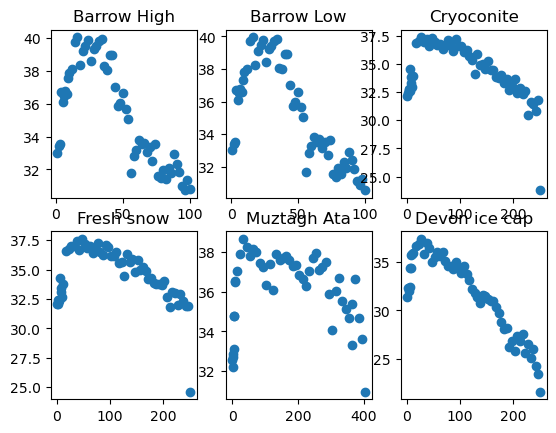

In [28]:
plots: dict = {0: (bHSQ, 'Barrow High'), 1: (bLSQ, 'Barrow Low'), 
                2: (crSQ, 'Cryoconite'), 3: (fsSQ, 'Fresh snow'), 
                4: (maSQ, 'Muztagh Ata'), 5: (diSQ, 'Devon ice cap')}
fig, ax = plt.subplots(2, 3)
count: int = 0
for i in range(2):
    for j in range(3):
        plot = plots[count][0]
        ax[i,j].scatter(plot['Position (bp)'], 
                        plot.iloc[:, 1:].mean(axis=1))
        ax[i,j].set(title=plots[count][1])
        count += 1

# Data cleaning
- Ordinarily, we clean fastq data by trimming the reads to a length with relatively high quality scores (e.g. the average quality at base 200+ is less than 30, so we trim to keep only the first 200 bases from the 5' end). Unfortunately, several of the samples in each site exhibit varying mean quality scores at the same base position. In addition to using a read trimmer, `dada2`, I will process the reads with a quality filter to retain high-confidence hits. An adapter filter will also be used because of the adapter content in some samples.  
- The read lengths I've trimmed to are listed in the `samplelist.tsv` file, along with the sample names

In [10]:
# View final results
crySeqs =  Artifact.load('results/1-Cleaning/Greenland_cryoconite-denoisedSeqs.qza')

# Sequence clustering

In [36]:
# First merge all samples into one
from qiime2.plugins.feature_table.methods import merge_seqs
from qiime2.plugins.feature_table.methods import merge
crySeqs = Artifact.load('results/2-OTUs/Greenland_cryoconite-otuSeqs.qza')
cryFreqs = Artifact.load('results/2-OTUs/Greenland_cryoconite-otuFreqs.qza')
snowSeqs = Artifact.load('results/2-OTUs/Greenland_cryoconite-otuFreqs.qza')
snowFreqs = Artifact.load('results/2-OTUs/Greenland_cryoconite-otuSeqs.qza')
barHSeqs = Artifact.load('results/2-OTUs/Barrow_Alaska_high-otuSeqs.qza')
barHFreqs = Artifact.load('results/2-OTUs/Barrow_Alaska_high-otuFreqs.qza')
barLSeqs = Artifact.load('results/2-OTUs/Barrow_Alaska_low-otuSeqs.qza')
barLFreqs = Artifact.load('results/2-OTUs/Barrow_Alaska_low-otuFreqs.qza')

In [32]:
mergedFreqs = Artifact.load('results/2-OTUs/Merged-otuFreqs.qza')
mergedSeqs = Artifact.load('results/2-OTUs/Merged-otuSeqs.qza')

# Taxonomic analyses
For sample taxonomic classification, I will be trying out all three of the methods available in qiime2: 

#### Database preparation
Two databases were obtained:

- All annotated 16S rRNA from the NCBI ftp [website](https://ftp-ncbi-nlm-nih-gov.ejournal.mahidol.ac.th/blast/db/v5/)
- Annotated 16S rRNA used by the tool [MicFunPred](https://github.com/microDM/MicFunPred)
- A 16S rRNA database from [EzBioCloud](https://www.ezbiocloud.net/dashboard)

The MicFunPred and NCBI databases were obtained in the standard BLAST format, and need to be converted into compatible data types for import into the qiime2 workflow. Specficially, I needed to convert them into FASTA format with an associated taxonomy mapping file (in HeaderlessTSVTaxonomyFormat)
- Steps
    - 1 Extract all entries from the database in FASTA format
    - 2 Extract the header and convert it into the HeaderLessTSVTaxonomyFormat, which is a tab-delimited file of FASTA identifiers followed by their taxonomic assignments
    - 3 Remove the taxonomic assignments from the original FASTA file
    - 4 Concatenate the respective files types together, then import them files as qiime2 Artifacts
    - 5 Repeat for the other database (if both databases used the identifier conventions I could have combined them and processed them together but unfortunately this was not the case )

```bash
# 1
blastdbcmd -db NCBI_16S/16S_ribosomal_RNA -entry all > NCBI_16S.fasta
blastdbcmd -db micfun/micfun16S -entry all > micfun.fasta

# 2 
grep '>' NCBI_16S.fasta | tr -d '>' | sed 's/ /\t/' | sed 's/ /_/g' > NCBI_16SID.txt
grep '>' micfun.fasta | tr -d '>' | sed 's/_/\t/' | sort | uniq > micfunID.txt # Unfortunately several of the headers repeat 

# 3 
cat micfun.fasta | sed 's/_.*//' > micfunID.fasta
cat NCBI_16S.fasta | sed 's/ .*//' > ncbi16sID.fasta

# 4 
cat micfunID.txt NCBI_16SID.txt EzBioCloud/ezbiocloud_id_taxonomy.txt > all_mappings.txt
cat EzBioCloud/ezbiocloud_qiime_full.fasta ncbi16sID.fasta micfun.fasta > all.fasta
qiime tools import     --type FeatureData[Taxonomy]     --input-format HeaderlessTSVTaxonomyFormat     --input-path all.fasta     --output-path all_fasta.qza
qiime tools import     --type FeatureData[Taxonomy]     --input-format HeaderlessTSVTaxonomyFormat     --input-path all_uniqIDs.txt     --output-path Ids.qza
```

- Altogether, the database contains 130,122 sequences (though there might be some repetition that was overlooked)

In [ ]:
# Script for removing redundant ids
from Bio import SeqIO
import csv

exists: set = set()
mapped = open('all_uniq.fasta', 'w+')
for seq in SeqIO.parse('all.fasta', 'fasta'):
    if seq.id in exists:
        continue
    exists.add(seq.id)
    mapped.write(f'>{seq.id}\n')
    mapped.write(f'{seq.seq}\n')
mapped.close

uniq = open('all_uniqIDs.txt', 'w+')
exists2: set = set()
with open('all_mappings.txt', 'r') as i:
    for id in csv.reader(i, delimiter='\t'):
        if id[0] in exists2:
            continue
        exists2.add(id[0])
        uniq.write(f'{id[0]}\t{id[1]}\n')
uniq.close


#### Merging with other data
The qiime2 website provides links for data resources, including 16s rRNA reference sequences. These are from the SILVA and greengenes databases

In [12]:
# Import database artifacts
IDs = Artifact.load('data/artifacts/Ids.qza') 
RefSeqs = Artifact.load('data/artifacts/all_fasta.qza')
silvaSeqs = Artifact.load('data/downloads/silva-138-99-seqs.qza')
silvaIDs = Artifact.load('data/downloads/silva-138-99-tax.qza')
greenSeqs = Artifact.load('data/downloads/2022.10.backbone.full-length.fna.qza')
greenIDs = Artifact.load('data/downloads/2022.10.backbone.tax.qza')
AllIDs = ftm.merge_taxa([IDs, silvaIDs, greenIDs])
AllSeqs = ftm.merge_seqs([RefSeqs, silvaSeqs, greenSeqs])
AllIDs.merged_data.save('data/artifacts/AllIDs.qza')
AllSeqs.merged_data.save('data/artifacts/AllSeqs.qza')

/home/sc31/Bio_SDD/miniconda3/envs/qiime2-2023.2/lib/python3.8/site-packages/q2_types/feature_data/_transformer.py:258: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id_, seq in data.iteritems():


### Taxonomic classification


# Diversity analyses

# References

# Load artifacts